In [1]:
### Jinrui Zhou
### MCB 112 - Pset 09: The Return of the Ten Arcs

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import special
from collections import Counter
import tqdm

In [3]:
%matplotlib inline

# 1. Write A Simulator as A Positive Control
### Write a function that simulates N=1000000 observed read counts, following the model specified above, for any Arc locus structure and any transcript abundances τ. Assume that there are 10 segments and isoforms. Use the function to generate a test data set for known model parameters τ, L that were chosen.

###### The 10 transcripts of the sand mouse Arc locus.

In [4]:
data1 = pd.read_csv('w09-data.out.1.txt', skiprows=[0], names=['Isoform', 'Transcripts', 'SegNum','Segments'], delim_whitespace=' ')
data1

,Isoform,Transcripts,SegNum,Segments
0,Arc1,xxxxx,4,ABCD
1,Arc2,xxxxx,2,BC
2,Arc3,xxxxx,3,CDE
3,Arc4,xxxxx,4,DEFG
4,Arc5,xxxxx,4,EFGH
5,Arc6,xxxxx,3,FGH
6,Arc7,xxxxx,2,GH
7,Arc8,xxxxx,2,HI
8,Arc9,xxxxx,3,IJA
9,Arc10,xxxxx,3,JAB


###### The 1000000 read sequences.

In [5]:
data2 = pd.read_csv('w09-data.out.2.txt', skiprows=[0], names=['Segment', 'readsLength'], delim_whitespace=' ')
data2

,Segment,readsLength
0,a,97512
1,b,268771
2,c,249157
3,d,76643
4,e,33977
5,f,40729
6,g,43351
7,h,76299
8,i,73029
9,j,40532


In [6]:
assigned_len = data1.SegNum.values.tolist()
assigned_len

[4, 2, 3, 4, 4, 3, 2, 2, 3, 3]

In [7]:
def initialize_abundance_length(n_transcript, min_len, max_len):
    abundance = list(np.random.dirichlet(np.ones(n_transcript),size=1)[0])
    lengths = list(np.random.randint(min_len, max_len+1, n_transcript))
    return abundance, lengths

In [8]:
def default_abundance_length(n_transcript):
    return list(np.random.dirichlet(np.ones(n_transcript),size=1)[0]), assigned_len

In [9]:
def create_reads(trans_vec, abundance_vec, len_transcripts, N):   
    reads = []
    temp = np.multiply(abundance_vec, len_transcripts)
    abundances = np.true_divide(temp, sum(temp))
    for i in tqdm.tqdm(range(N)):
        transcript = trans_vec[np.random.choice(len(trans_vec),p=abundances)]
        reads.append(np.random.choice(transcript))        
    return reads

In [10]:
def generate_arc(len_transcripts):    
    transcripts = []
    lts = len(len_transcripts)
    segment = [i for i in range(lts)]
    for start_idx, trans_len in enumerate(len_transcripts):
        if start_idx+trans_len > lts:  
            transcripts.append(segment[start_idx:]+segment[:start_idx+trans_len - lts])
        else: 
            transcripts.append(segment[start_idx:start_idx+trans_len])  
    return transcripts

In [11]:
trans_abundance, len_transcripts = initialize_abundance_length(10, min_len=2, max_len=4)

In [12]:
print(trans_abundance)
print(len_transcripts)

[0.05971327890305918, 0.23354981722220802, 0.029466560356696325, 0.12340591105142255, 0.12437230446875248, 0.01655287568767354, 0.07309621171605585, 0.13848334897256215, 0.042741947704902444, 0.15861774391666758]
[2, 4, 3, 4, 4, 4, 4, 2, 2, 3]


In [13]:
transcript_list = generate_arc(len_transcripts)
transcript_list

[[0, 1],
 [1, 2, 3, 4],
 [2, 3, 4],
 [3, 4, 5, 6],
 [4, 5, 6, 7],
 [5, 6, 7, 8],
 [6, 7, 8, 9],
 [7, 8],
 [8, 9],
 [9, 0, 1]]

In [14]:
reads = create_reads(transcript_list, trans_abundance, len_transcripts, 1000000)
df_reads = pd.DataFrame.from_dict(Counter(reads), orient="index").reset_index()
df_reads.columns = ["read", "counts"]
df_reads["read_char"] = df_reads.read.apply(lambda x: chr(ord('@')+x+1))
df_reads = df_reads.sort_values("read",ignore_index=True)
df_reads["frequency"] = round(df_reads.counts/df_reads.counts.values.sum(),2)
df_reads

100%|██████████| 1000000/1000000 [00:23<00:00, 42359.97it/s]


,read,counts,read_char,frequency
0,0,65162,A,0.07
1,1,135849,B,0.14
2,2,79349,C,0.08
3,3,116061,D,0.12
4,4,153092,E,0.15
5,5,79651,F,0.08
6,6,100911,G,0.10
7,7,105968,H,0.11
8,8,81618,I,0.08
9,9,82339,J,0.08


###### Rerun the code using the assigned lengths [4, 2, 3, 4, 4, 3, 2, 2, 3, 3].

In [15]:
abundances, len_transcripts = default_abundance_length(10)
transcripts = generate_arc(assigned_len)
reads = create_reads(transcripts, abundances, assigned_len, 1000000)

df2 = pd.DataFrame.from_dict(Counter(reads), orient="index").reset_index()
df2.columns = ["read", "counts"]
df2["read_char"] = df2.read.apply(lambda x: chr(ord('@')+x+1))
df2 = df2.sort_values("read",ignore_index=True)
df2["frequency"] = round(df2.counts/df2.counts.values.sum(),2)
df2

100%|██████████| 1000000/1000000 [00:23<00:00, 42303.81it/s]


,read,counts,read_char,frequency
0,0,68088,A,0.07
1,1,49848,B,0.05
2,2,64233,C,0.06
3,3,97080,D,0.10
4,4,141874,E,0.14
5,5,136351,F,0.14
6,6,202064,G,0.20
7,7,149448,H,0.15
8,8,45882,I,0.05
9,9,45132,J,0.05


# 2. Calculate the Log Likelihood
### Write a function that calculates the log likelihood: the log probability of the observed data (the observed read counts rk) if the model and its parameters were known (i.e. τ, L), for a given locus structure of Arc. Explain the steps of the calculation.

In [16]:
def nuc_to_trans(abundances,len_transcripts):
    abundances = np.true_divide(abundances, len_transcripts)
    return np.true_divide(abundances, sum(abundances))

In [17]:
def trans_to_nuc(abundances,len_transcripts):
    ab = np.multiply(abundances, len_transcripts)
    return np.true_divide(ab, sum(ab)) 

In [18]:
def nll(reads, transcripts, abundances, len_transcripts): 
    log_probs = []
    for read_idx, read in enumerate(unique_reads):  
        read_probs = []
        for idx, transcript in enumerate(transcripts): 
            if read in transcript:
                read_probs.append(np.log(abundances[idx]/len_transcripts[idx])) 
        read_prob_sum = special.logsumexp(read_probs)*unique_counts[read_idx]  
        log_probs.append(read_prob_sum)
    res = -np.sum(log_probs) 
    return res

###### Run the given code for the analysis done by Lestrade et al.
###### The script estimates the number of reads assigned to each isoform by assigning each read to its cognate segment, trusting the mapping and ignoring accuracy; then assigning to isoform uniformly. (i.e. if 3 isoforms share the same segment, assign 1/3 count to each isoform.)

In [20]:
import numpy as np
import string
import sys
import re

T = 10
S = T    # S = R = T : there are T transcripts (Arc1..Arc10), S segments (A..J), R reads (a..j)
R = T
Slabel   = list(string.ascii_uppercase)[:S]               # ['A'..'J']        : the upper case labels for Arc locus segments 
Tlabel   = [ "Arc{}".format(d) for d in range(1,T+1) ]    # ['Arc1'..'Arc10'] : the labels for Arc transcript isoforms
Rlabel   = list(string.ascii_lowercase)[:T]               # ['a'..'j']        : lower case labels for reads

In [21]:
print(Slabel)
print(Tlabel)
print(Rlabel)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
['Arc1', 'Arc2', 'Arc3', 'Arc4', 'Arc5', 'Arc6', 'Arc7', 'Arc8', 'Arc9', 'Arc10']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']


### Use Lestrade's approach with his code to estimate abundances of each Arc isoform in the test dataset. Compare to the new true τ. Calculate and show the log likelihood given what Lestrade would estimate for the τ, compared to the log likelihood for the true τ in the positive control.

In [22]:
segusage = np.zeros(S).astype(int)
L = assigned_len
r = df2.counts.tolist()
for i in range(T):
    for j in range(i,i+L[i]): 
        segusage[j%S] += 1
c  = np.zeros(T)
for i in range(T):
    for k in range(i,i+L[i]):
        c[i] += (1.0 / float(segusage[k%S])) * float(r[k%S])  
Z = np.sum(c)
est_nu  = np.divide(c, Z)       # nucleotide abundance

print(c)

est_tau = np.divide(est_nu, L)  # convert to TPM, transcript abundance
est_tau = np.divide(est_tau, np.sum(est_tau))

# Print a table of the resulting estimates for tau
for i in range(T):
    print ("{0:10s}  {1:5.3f}".format(Tlabel[i], est_tau[i]))

[ 93083.          38027.         101062.33333333 175617.66666667
 180619.66666667 133328.33333333  87878.          60303.
  68203.          61878.        ]
Arc1        0.071
Arc2        0.058
Arc3        0.103
Arc4        0.134
Arc5        0.138
Arc6        0.136
Arc7        0.134
Arc8        0.092
Arc9        0.070
Arc10       0.063


### Calculate and show the log likelihood of one of the new generated test data sets, for the known parameter values.

In [23]:
unique_reads = df2.read.tolist()
unique_counts = df2.counts.tolist()

In [24]:
trans_to_nuc(abundances, assigned_len)

array([0.0930644 , 0.04792982, 0.05068599, 0.22759581, 0.27566147,
       0.03081334, 0.13182389, 0.00749522, 0.12705759, 0.00787247])

In [25]:
trans_to_nuc(est_tau, assigned_len)

array([0.093083  , 0.038027  , 0.10106233, 0.17561767, 0.18061967,
       0.13332833, 0.087878  , 0.060303  , 0.068203  , 0.061878  ])

In [26]:
true_nll = nll(reads, transcripts, trans_to_nuc(abundances, assigned_len), assigned_len)
true_nll

2172347.142230456

In [27]:
les_nll = nll(reads, transcripts, trans_to_nuc(est_tau, assigned_len), assigned_len)
les_nll

2179091.1282082503

In [145]:
print("The negative log-likelihood of the true parameters is %.2f" %round(true_nll, 2))
print("The negative log-likelihood of Lestrade's parameters is %.2f" %round(les_nll, 2))
print("Lestrade's nll is %.2f greater than the true log-likelihood."%round(np.abs(true_nll-les_nll), 2))  

The negative log-likelihood of the true parameters is 2172347.14
The negative log-likelihood of Lestrade's parameters is 2179091.13
Lestrade's nll is 6743.99 greater than the true log-likelihood.


### The result shows that the negative log-likelihood of Lestrade's parameters is 6743.99 greater than the one of the true parameters, meaning that the true τ parameter values give a much better log likelihood than the Lestrade et al. estimates.

# 3. Estimate Isoform Abundances by EM
### Write a function that estimates unknown isoform abundances τi for each isoform Arc1..Arc10, given read counts r_k and the structure of the Arc locus including the lengths Li, using expectation maximization. Apply the function to the data in the Lestrade et al. supplementary data file. Show the estimated τi. What are the most abundant two transcripts, and how much of the population do they account for? What are the least abundant two transcripts? Explain why Lestrade was wrong.

In [31]:
def EM(reads, transcripts, lengths, iterations):
    trans_abundances = nuc_to_trans(initialize_abundance_length(len(transcripts), 1,1)[0], lengths)
    unique_reads, unique_counts = np.unique(reads, return_counts=True)
    nlls = []
    print("Training with %i iterations, threshold set at %f"%(iteration, threshold))
    for i in range(iterations):
        total_counts = np.zeros(10)   
        for read_idx, read in enumerate(unique_reads):  
            read_probs = []
            idxs = []   
            for idx, transcript in enumerate(transcripts):
                if read in transcript:
                    idxs.append(idx)
                    read_probs.append(np.log(trans_abundances[idx]/lengths[idx]))
            read_probs = np.subtract(read_probs, special.logsumexp(read_probs))
            read_counts = np.multiply(np.exp(read_probs),unique_counts[read_idx])  
            np.add.at(total_counts, idxs, read_counts)
        trans_abundances = np.divide(total_counts, np.sum(total_counts))
        nl = nll(reads, transcripts, trans_to_nuc(trans_abundances, lengths), lengths)                       
        if not nlls:
            nlls.append(nl)
            continue
        elif np.abs(np.subtract(nlls[-1], nl)) < threshold:
            nlls.append(nl)
            print("Training converged at step %i"%i)
            return trans_abundances, nlls
        else: 
            nlls.append(nl)                              
    print("Reached max iteration.")
    return trans_abundances, nlls

In [139]:
threshold = 0.01
iteration = 10000

reads = []
for read, counts in zip(list(range(0, 10)),assigned_len):
    reads += [read]*counts
transcripts = generate_arc(data1.SegNum.tolist())
lengths = data1.SegNum.tolist()

EM_abundances, EM_nlls = EM(reads, transcripts, lengths, iteration)

Training with 10000 iterations, threshold set at 0.010000
Training converged at step 1689


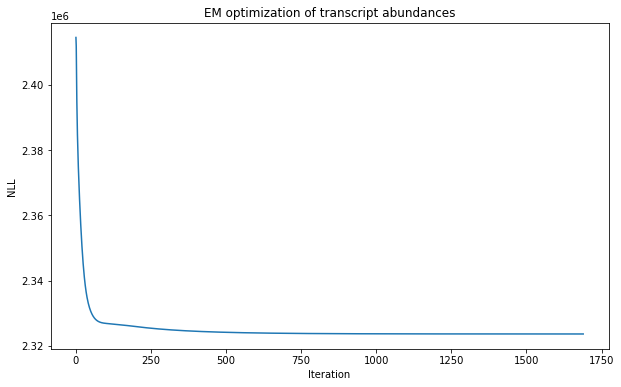

In [140]:
plt.figure(figsize=(10,6))
plt.plot(EM_nlls)
plt.xlabel("Iteration")
plt.ylabel("NLL")
plt.title("EM optimization of transcript abundances")
plt.show()

In [141]:
df = pd.DataFrame(np.array([data2.Segment.str.upper().tolist(), EM_abundances, est_tau, np.abs(np.subtract(EM_abundances, est_tau))]).T, 
                  columns=["Arc","EM abundance", "Les abundance", "Differences"])
df

,Arc,EM abundance,Les abundance,Differences
0,A,0.13332589312003337,0.07118077756112158,0.06214511555891179
1,B,0.01666631759630759,0.05815866330730145,0.04149234571099386
2,C,0.17500672091958938,0.10304345539368696,0.07196326552590242
3,D,0.16666821323255154,0.13429522111237494,0.03237299212017661
4,E,0.13331893843973036,0.13812026166071062,0.004801323220980258
5,F,0.02500984930446906,0.1359419648785861,0.11093211557411703
6,G,4.63227553374338e-81,0.1344010049206889,0.1344010049206889
7,H,0.05000111560465031,0.09222767700371313,0.04222656139906283
8,I,0.22499729729040494,0.06953998147891201,0.1554573158114929
9,J,0.0750056544922635,0.06309099268290425,0.011914661809359253


In [144]:
print("The negative log-likelihood of EM optimized parameters is %.2f"%EM_nlls[-1])
print("The negative log-likelihood of Lestrades' parameters is %.2f"%les_nll)
print("Lestrade's nll is %.2f greater than the EM optimized log-likelihood."%np.abs(les_nll - EM_nlls[-1]))

The negative log-likelihood of EM optimized parameters is 2323652.19
The negative log-likelihood of Lestrades' parameters is 2179091.13
Lestrade's nll is 144561.06 greater than the EM optimized log-likelihood.


### The result shows that the negative log-likelihood of Lestrade's parameters is 6743.99 greater than the one of the EM optimized parameters.

In [165]:
df['EM abundance'] = df['EM abundance'].astype(float)
df['Les abundance'] = df['Les abundance'].astype(float)
df['Differences'] = df['Differences'].astype(float)

In [166]:
df.sort_values("EM abundance", ascending=False)

,Arc,EM abundance,Les abundance,Differences
8,I,2.249973e-01,0.069540,0.155457
2,C,1.750067e-01,0.103043,0.071963
3,D,1.666682e-01,0.134295,0.032373
0,A,1.333259e-01,0.071181,0.062145
4,E,1.333189e-01,0.138120,0.004801
9,J,7.500565e-02,0.063091,0.011915
7,H,5.000112e-02,0.092228,0.042227
5,F,2.500985e-02,0.135942,0.110932
1,B,1.666632e-02,0.058159,0.041492
6,G,4.632276e-81,0.134401,0.134401


In [167]:
print(" Arc I and C are the most expressed as these two are the most abundant.\n They account for %.2f of transcripts"%
      (df['EM abundance'][8]+df['EM abundance'][2]))

 Arc I and C are the most expressed as these two are the most abundant.
 They account for 0.40 of transcripts


In [168]:
print(" Arc B and G are the least expressed as these two are the least abundant.\n They account for %.2f of transcripts"%
      (df['EM abundance'][1]+df['EM abundance'][6]))

 Arc B and G are the least expressed as these two are the least abundant.
 They account for 0.02 of transcripts


<AxesSubplot:xlabel='Arc'>

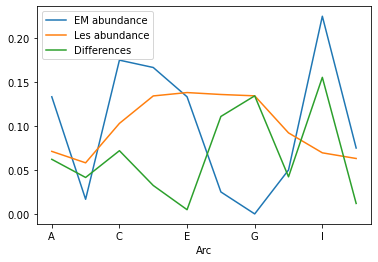

In [169]:
df.set_index("Arc").astype(float).plot()

In [170]:
df['EM abundance'][2]/df['EM abundance'][3]

1.0500305818686804

In [171]:
df['Les abundance'][2].astype(float)/df['Les abundance'][3].astype(float)

0.7672905598588854

### Based on the result, Arc2 and Arc3 both have a relative high rank in terms of EM abundance but not for the result gotten from the Lestrade's method. Lestrade et al. believed that the transcript isoform abundances are nearly uniform which is not true proved by testing even though it is reasonable to claim that some of them are close. By calculation, the abundnace of Arc2 is roughly 1.05 times greater thanthe abundance of Arc3. For Lestrade's estimation, the abundnace of Arc2 is roughly 0.77 times less thanthe abundance of Arc3. Therefore, their conclusion was incorrect. Even though the plot showing the EM abundance, Lestrade's abundance, and the difference look bad, it directly indicates that transcripts are not uniformly distributed. The problem for the Lestrade's method is that they simply compute the nucleotide abundance by assuming a uniform distribution and performing $1/L_i$, which is inappropriate.